In [2]:
pip install coremltools

     -------------------------------------- 882.2/882.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Created wheel for coremltools: filename=coremltools-6.1-py3-none-any.whl size=1181394 sha256=df65bb4cfeb46cdff85b6abbc8e05a6cee5ebc536aa94463669b84300e591751
  Stored in directory: c:\users\fifid\appdata\local\pip\cache\wheels\99\ee\ce\eefc6b284a2999bd688ec5663be3c2dc367a306cf23bb15d87
Successfully built coremltools


In [7]:
pip install keras_preprocessing livelossplot


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import pandas as pd
import string
import random
import matplotlib
import numpy as np
#import coremltools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from keras import backend as K
from ast import literal_eval
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from livelossplot import PlotLossesKeras
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [2]:
import PIL
import os
import os.path
from PIL import Image

f = r'Ressources_Test\images'
for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    img = img.resize((224,224))
    img.save(f_img)

In [57]:
# Download dataset from https://www.kaggle.com/greg115/various-tagged-images
DATASET_PATH = 'Ressources_Test\images' # Directory of the images with the following format "id-tag1_tag2.jpg"
METADATA_PATH = 'Ressources_Test\img_attributes.csv' #modif
IMAGE_PATH_KEY = "image_path"
TAGS_PATH_KEY = "tags"
MODEL_PATH = "./checkpoint.h5"
IMAGE_SIZE = 224 # pas modif car sinon pb avec fully connected
BATCH_SIZE = 16 #nb d'images en entrée du réseau en même temps
TESTING_SIZE = 200 #modif
VALIDATION_SPLIT = 0.1 # a modif
RANDOM_SEED = 115
EPOCHS = 100 #combien de fois on visualise l'ensemble des images du dataset, au moins 100
DROPOUT = 0.3 #0.2 ou 0.3
FULLY_CONNECTED = 1024
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = LEARNING_RATE/100.0
CONFIDENCE_THRESHOLD = 0.9

In [38]:
# Loading metadata and splitting into training/validation and testing sets
df_old = pd.read_csv(METADATA_PATH)
#print(list(df[df.columns[0]]))
att_to_crop = ["Arched_Eyebrows","Attractive","Blurry","Double_Chin", "Narrow_Eyes"]

y = []
for row in df_old.iterrows():

    sub_y = []
    for i in range(1,len(row[1])) :
        if (int(row[1][i])==1):
            #if df_old.columns.values[i] == 'Male' or df_old.columns.values[i] == 'Smiling':
            if all(df_old.columns.values[i] != att for att in att_to_crop):
                sub_y.append(df_old.columns.values[i])
    y.append(sub_y)
    
#print(y)
df = pd.DataFrame(list(zip(list(df_old[df_old.columns[0]]), y)),
               columns =['image_path', 'tags'])
print(df.head(15))
#print(df.shape[0])

    image_path                                               tags
0   000001.jpg  [Brown_Hair, Heavy_Makeup, High_Cheekbones, Mo...
1   000002.jpg  [Bags_Under_Eyes, Big_Nose, Brown_Hair, High_C...
2   000003.jpg  [Big_Lips, Male, No_Beard, Pointy_Nose, Wavy_H...
3   000004.jpg  [No_Beard, Pointy_Nose, Straight_Hair, Wearing...
4   000005.jpg  [Big_Lips, Heavy_Makeup, No_Beard, Pointy_Nose...
5   000006.jpg  [Big_Lips, Brown_Hair, Heavy_Makeup, Mouth_Sli...
6   000007.jpg  [5_o_Clock_Shadow, Bags_Under_Eyes, Big_Lips, ...
7   000008.jpg  [5_o_Clock_Shadow, Bags_Under_Eyes, Big_Lips, ...
8   000009.jpg  [Bangs, Big_Lips, Heavy_Makeup, High_Cheekbone...
9   000010.jpg  [Heavy_Makeup, High_Cheekbones, No_Beard, Wavy...
10  000011.jpg  [Black_Hair, Mouth_Slightly_Open, No_Beard, Sm...
11  000012.jpg  [Bags_Under_Eyes, Black_Hair, Bushy_Eyebrows, ...
12  000013.jpg  [Blond_Hair, High_Cheekbones, Male, Mouth_Slig...
13  000014.jpg  [Big_Nose, Black_Hair, Bushy_Eyebrows, Heavy_M...
14  000015

In [39]:
training_and_validation_size = df.shape[0] - TESTING_SIZE

print(training_and_validation_size)

training_df = df[:training_and_validation_size]
testing_df = df[training_and_validation_size:]

#training_df[TAGS_PATH_KEY] = training_df[TAGS_PATH_KEY].apply(lambda x:literal_eval(x))
training_df
testing_df

800


,image_path,tags
800,000801.jpg,"[5_o_Clock_Shadow, Bags_Under_Eyes, Big_Lips, ..."
801,000802.jpg,"[Mouth_Slightly_Open, No_Beard, Smiling, Young]"
802,000803.jpg,"[High_Cheekbones, Male, No_Beard, Young]"
803,000804.jpg,"[Blond_Hair, Heavy_Makeup, High_Cheekbones, Mo..."
804,000805.jpg,"[Big_Lips, No_Beard, Pointy_Nose, Straight_Hai..."
...,...,...
995,000996.jpg,"[Bangs, Blond_Hair, Heavy_Makeup, High_Cheekbo..."
996,000997.jpg,"[Bangs, Blond_Hair, Heavy_Makeup, No_Beard, Pa..."
997,000998.jpg,"[Blond_Hair, Heavy_Makeup, Mouth_Slightly_Open..."
998,000999.jpg,"[Male, No_Beard]"


In [41]:
# Getting labels
all_labels = [] 

for tags in training_df[TAGS_PATH_KEY].values.tolist():
    for tag in tags:
        all_labels.append(tag)
        
#unique_labels = list(df_old.columns.values[1:])
unique_labels = list(np.unique(all_labels))


In [14]:
#print(unique_labels)
#print(all_labels)
print(type(unique_labels))
#print(type(all_labels))
print(type(unique_labels[0]))
print(type(all_labels[0]))

<class 'list'>
<class 'numpy.str_'>
<class 'str'>


In [42]:
training_data_generator = ImageDataGenerator(rotation_range=30,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             shear_range=0.2,
                                             horizontal_flip=True,
                                             fill_mode="nearest",
                                             validation_split=VALIDATION_SPLIT,
                                             preprocessing_function=preprocess_input)

training_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                 directory=DATASET_PATH,
                                                                 x_col=IMAGE_PATH_KEY, 
                                                                 y_col=TAGS_PATH_KEY,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=RANDOM_SEED,
                                                                 class_mode="categorical",
                                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                 subset="training")

validation_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                   directory=DATASET_PATH,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=TAGS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                                   subset="validation")



Found 720 validated image filenames belonging to 35 classes.
Found 80 validated image filenames belonging to 35 classes.


In [43]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p++K.epsilon()))

def get_model():
    def model(backbone):
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dropout(DROPOUT))
        model.add(BatchNormalization())
        model.add(Dense(FULLY_CONNECTED, activation='relu'))
        model.add(Dense(len(unique_labels), activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(lr=LEARNING_RATE, decay=LEARNING_RATE_DECAY),
                      metrics=["accuracy", recall, precision, f1])
        return model

    backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    return model(backbone)

model = get_model()

C:\Users\melea\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [25]:
# Setting class weights to handle imbalanced data
#class_weights = class_weight.compute_class_weight('balanced',unique_labels, all_labels)

#print(class_weights)

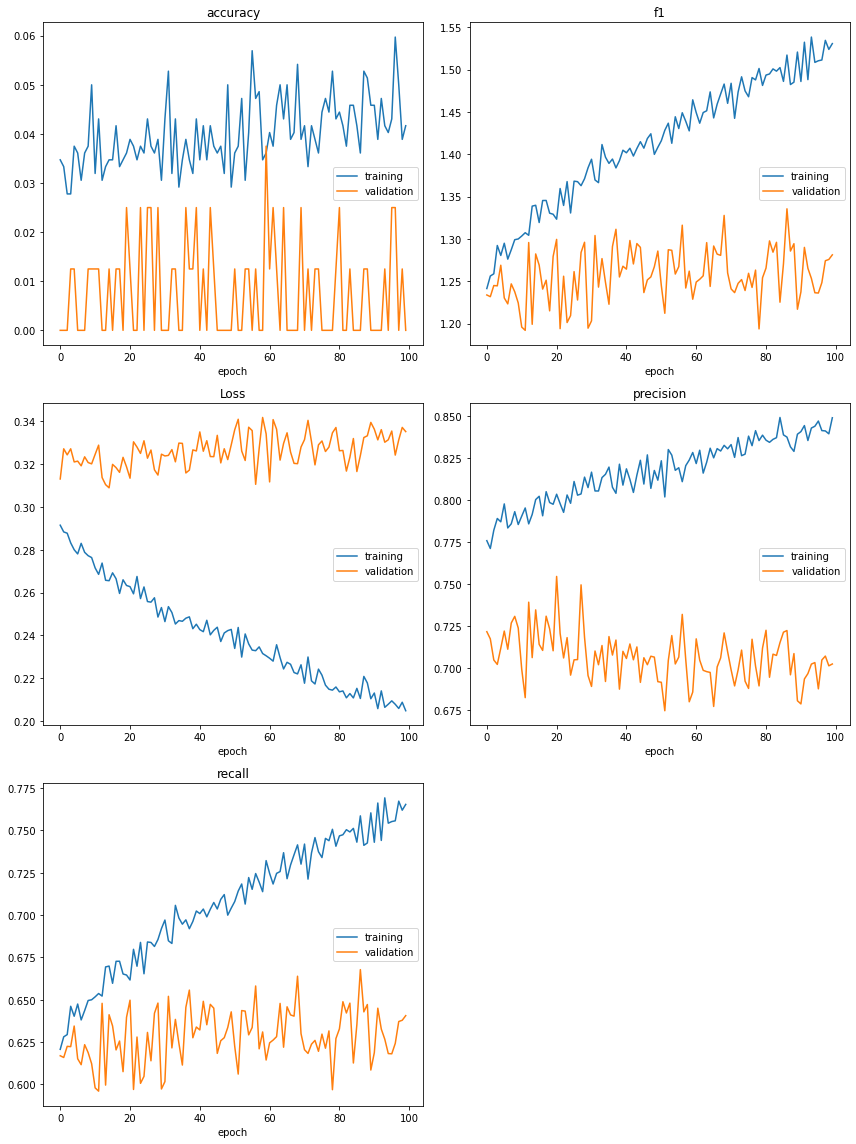

accuracy
	training         	 (min:    0.028, max:    0.060, cur:    0.042)
	validation       	 (min:    0.000, max:    0.038, cur:    0.000)
f1
	training         	 (min:    1.241, max:    1.538, cur:    1.531)
	validation       	 (min:    1.192, max:    1.336, cur:    1.281)
Loss
	training         	 (min:    0.205, max:    0.291, cur:    0.205)
	validation       	 (min:    0.309, max:    0.342, cur:    0.335)
precision
	training         	 (min:    0.771, max:    0.849, cur:    0.849)
	validation       	 (min:    0.675, max:    0.755, cur:    0.702)
recall
	training         	 (min:    0.621, max:    0.769, cur:    0.765)
	validation       	 (min:    0.596, max:    0.668, cur:    0.641)

Epoch 100: val_f1 did not improve from 1.33557
45/45 [==============================] - 13s 292ms/step - loss: 0.2048 - accuracy: 0.0417 - recall: 0.7654 - precision: 0.8491 - f1: 1.5308 - val_loss: 0.3352 - val_accuracy: 0.0000e+00 - val_recall: 0.6406 - val_precision: 0.7024 - val_f1: 1.2812


In [58]:
# Training
model.fit(x=training_generator,
                  
                    steps_per_epoch=training_generator.n // training_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[PlotLossesKeras(), 
                               ModelCheckpoint(MODEL_PATH,
                                               monitor='val_f1',
                                               mode='max',
                                               save_best_only=True,
                                               verbose=1)],
                    epochs=EPOCHS)
model = load_model(MODEL_PATH, custom_objects={"f1": f1, "recall": recall,"precision": precision})
#model = model.load_weights(MODEL_PATH)

In [59]:
# Testing
testing_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testing_generator = testing_data_generator.flow_from_dataframe(dataframe=testing_df,
                                                               directory=DATASET_PATH,
                                                               x_col=IMAGE_PATH_KEY,
                                                               batch_size=1,
                                                               seed=RANDOM_SEED,
                                                               shuffle=False,
                                                               class_mode=None,
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE))
predictions = model.predict(testing_generator,
                                      steps=TESTING_SIZE,
                                      verbose=1)

Found 200 validated image filenames.
200/200 [==============================] - 5s 22ms/step


In [65]:
def show_images(images, titles, rows):
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        subplot = fig.add_subplot(rows, int(np.ceil(len(images)/float(rows))), n + 1)
        plt.imshow(image)
        subplot.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * len(images))
    plt.savefig("results.png", bbox_inches="tight", pad_inches=0)
    plt.show()
    plt.close()
    
images = []
images_path = []
titles = []

top_n = 5

for prediction_index, prediction in enumerate(predictions):
    title = []
    top_n_indices = np.argpartition(prediction, -top_n)[-top_n:]
    for top_n_index in top_n_indices:
        if prediction[top_n_index]*100 >40 :
            title.append(unique_labels[top_n_index] + " %.1f" % (prediction[top_n_index]*100) + "%")
            
    image_path = DATASET_PATH + '/' + testing_generator.filenames[prediction_index]
    img = mpimg.imread(image_path)
    images_path.append(image_path)
    images.append(img)
    titles.append(title)
#show_images(images, titles, len(images))

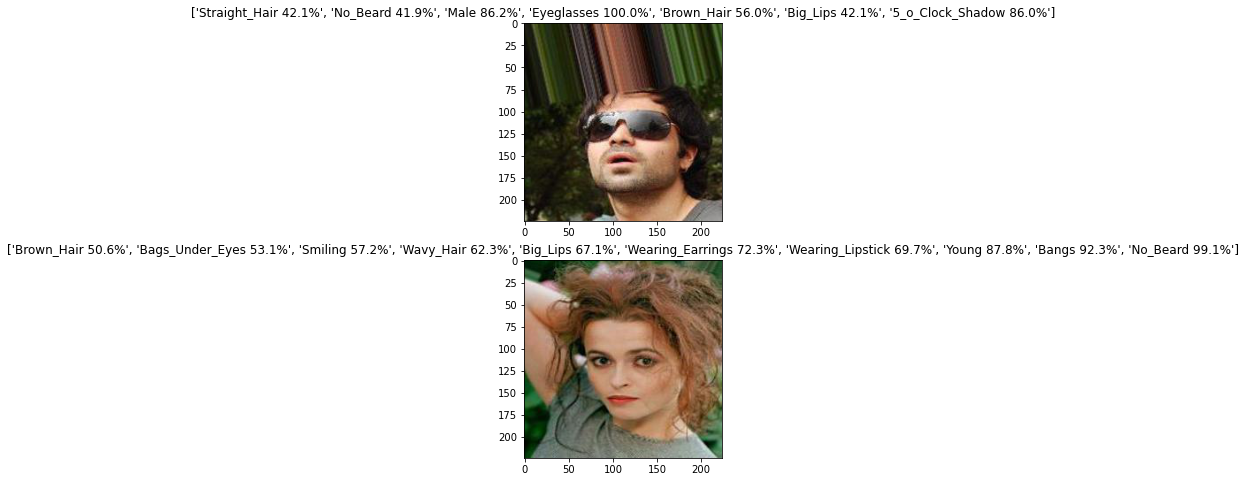

In [82]:
imgs = [images[103],images[108]]
titl = [titles[103],titles[108]]
'''

img1 = 'Ressources_Test\images/000819.jpg'
img2 = 'Ressources_Test\images/000909.jpg'
imgs = [mpimg.imread(img1),mpimg.imread(img2)]
for e in images_path:
    if e == img1 or e == img2:
        titl = titles[i]
        titl.sort()
        print(images_path[i], titl)
'''
show_images(imgs, titl, len(imgs))